<AxesSubplot:xlabel='year'>

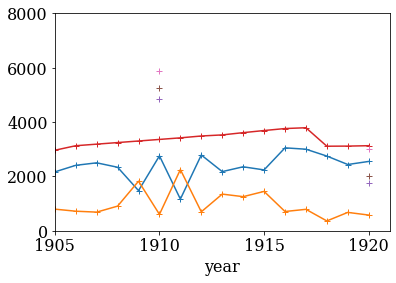

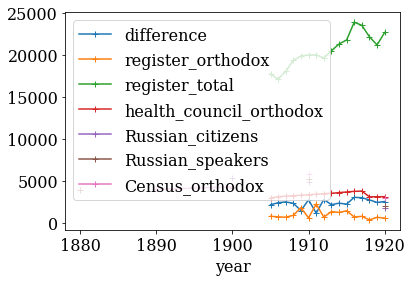

In [34]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

data_dir = Path('../data')
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['total'] = poll_tax.total_women + poll_tax.total_men
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1905, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([
    difference,
    poll_tax.orthodox,
    poll_tax.total,
    health_council,
    foreigners,
    language,
    religion,
]).T
data.columns = [
    'difference',
    'register_orthodox',
    'register_total',
    'health_council_orthodox',
    'Russian_citizens',
    'Russian_speakers',
    'Census_orthodox',
]
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=False, xlim=(1905, 1921), ylim=(0, 8000))
data.plot(marker='+')

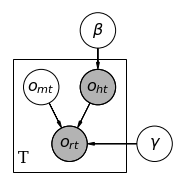

In [35]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

# pgm.add_node('sigma', r'$\sigma_{\beta}$', 1, 3, fixed=True)
# pgm.add_node('mu', r'$\mu_{\beta}$', 2, 4, fixed=True)
pgm.add_node('health_orthodox', r'$o_{ht}$', 2, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_{rt}$', 1.5, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('missing_orthodox', r'$o_{mt}$', 1, 2, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_city', r'$\beta$', 2, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('gamma', r'$\gamma$', 3, 1, fixed=False, scale=scale, observed=False)

# pgm.add_edge('sigma', 'beta_orthodox_city', directed=True)
# pgm.add_edge('mu', 'beta_orthodox_city', directed=True)
pgm.add_edge('beta_orthodox_city', 'health_orthodox', directed=True)
pgm.add_edge('gamma', 'register_orthodox', directed=True)
pgm.add_edge('health_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('missing_orthodox', 'register_orthodox', directed=True)

pgm.add_plate([0.5, 0.5, 2, 2], 'T')

pgm.render()

Model:

$ o_{rt} = \gamma o_{ht} - o_{mt} $

$ \gamma \sim N(0.8, 0.1^2) $

$ o_{mt} \sim N(0.5, 0.1^2) $

$ o_{ht} \sim N(\mu_{o_{ht}}, 0.01^2) $

$ \mu_{o_{ht}} = \beta_0 + \beta_1 t $

$ \beta \sim N\begin{pmatrix}\begin{bmatrix} 0.75 \\ 0.02 \end{bmatrix},
 \begin{bmatrix} 0.02 && 0 \\ 0 && 0.002 \end{bmatrix}\end{pmatrix} $

c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\antth\pycharmprojects\vyborg_orthodox\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_m, gamma, beta_1, beta_0]
Sampling 2 chains for 1_000 tune and 1_000 draw 

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

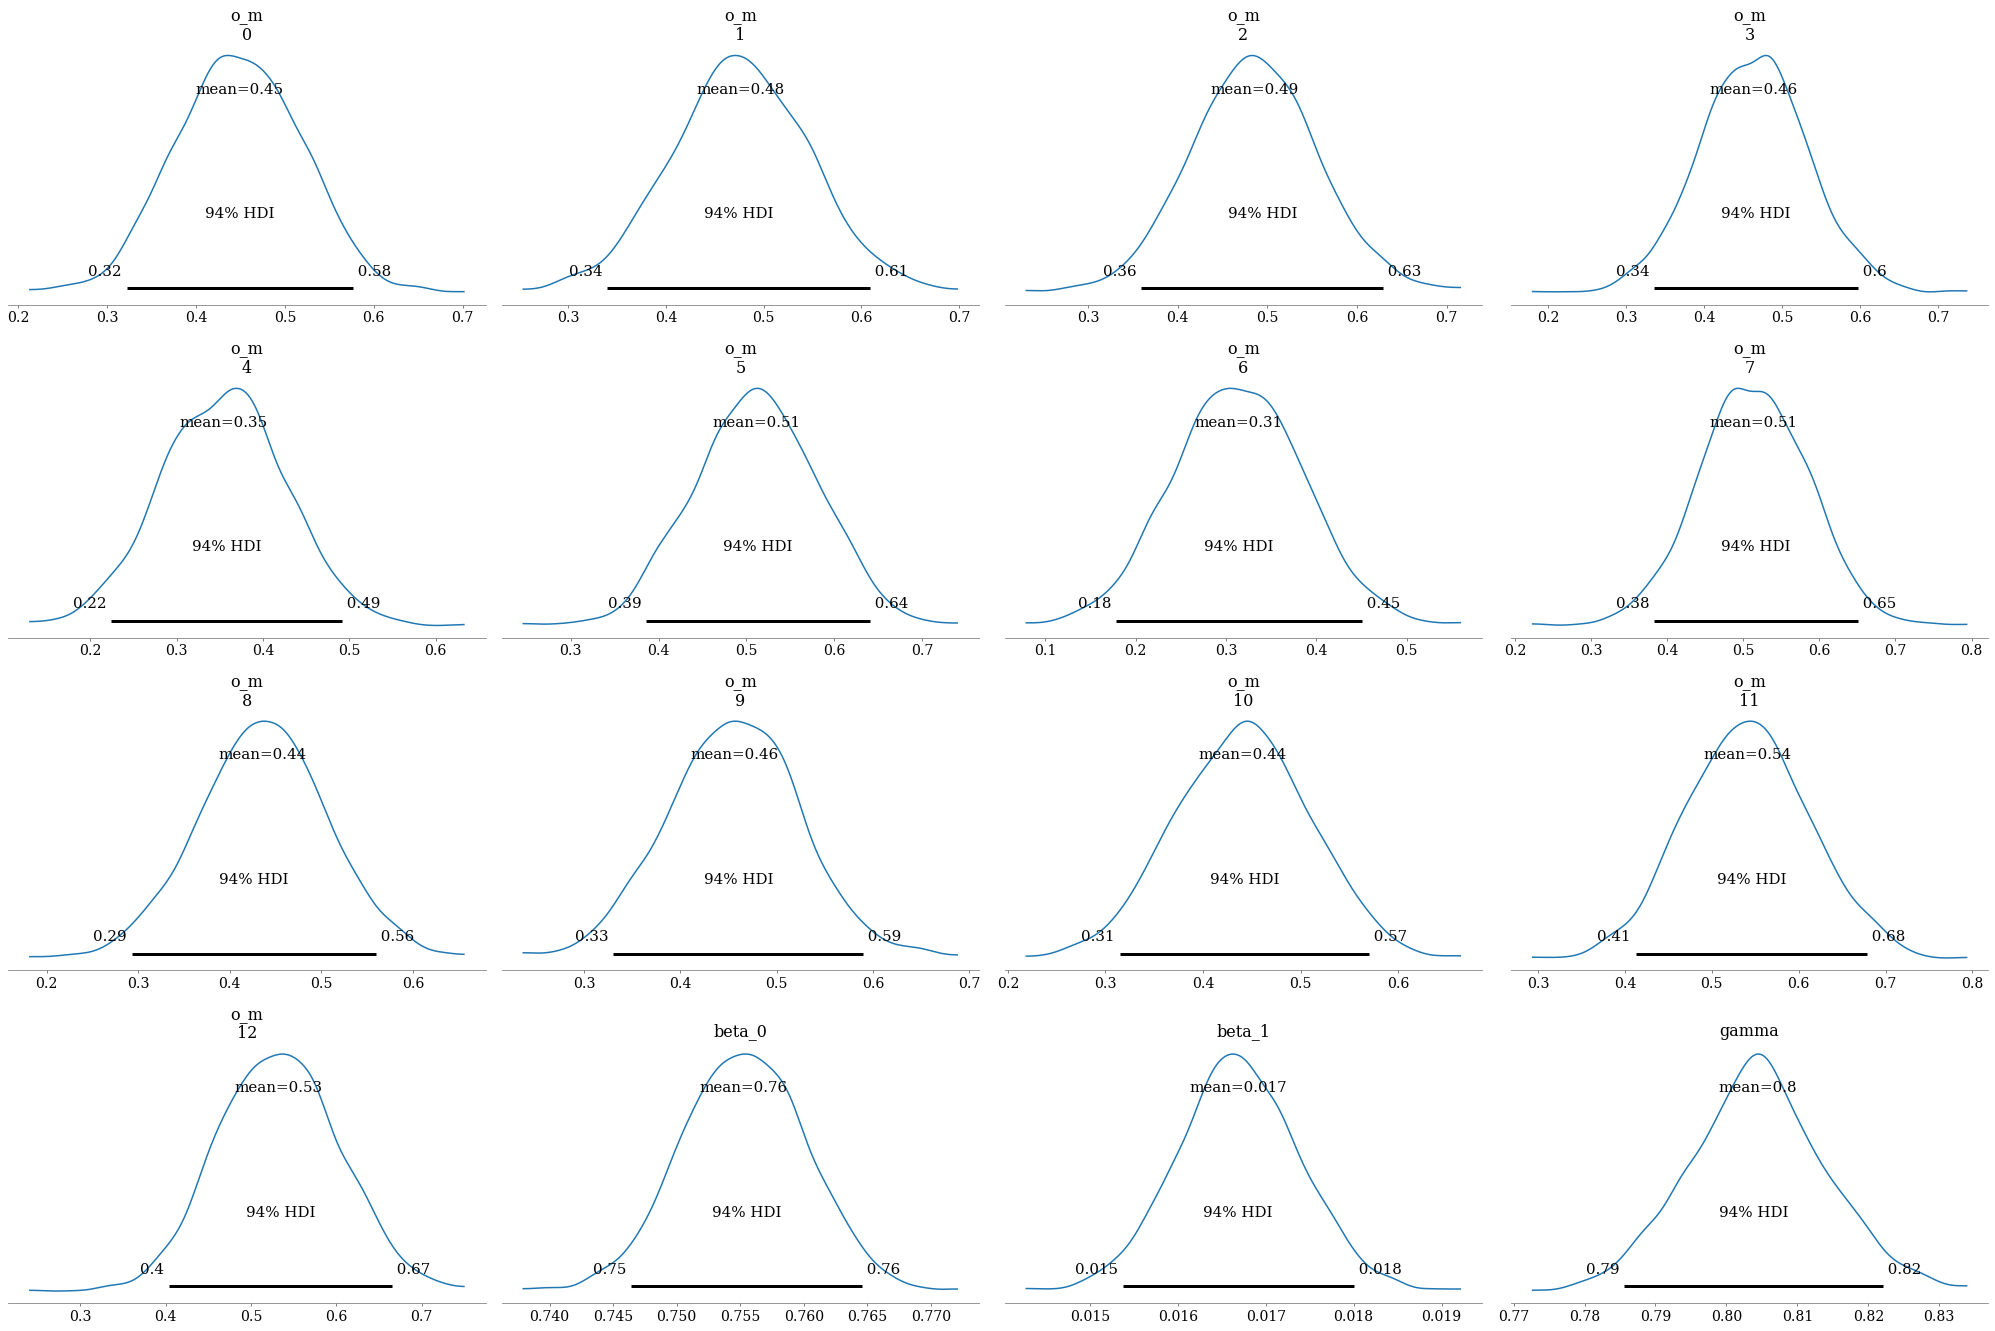

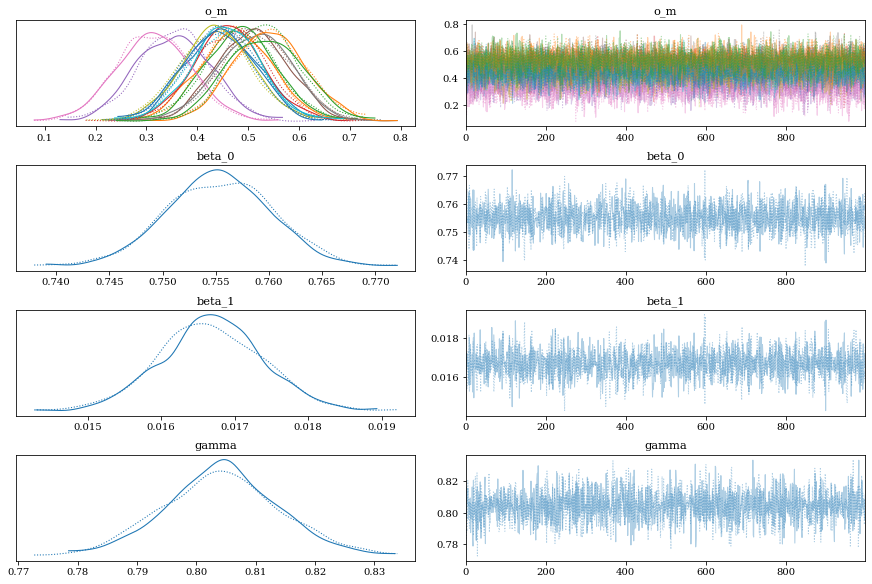

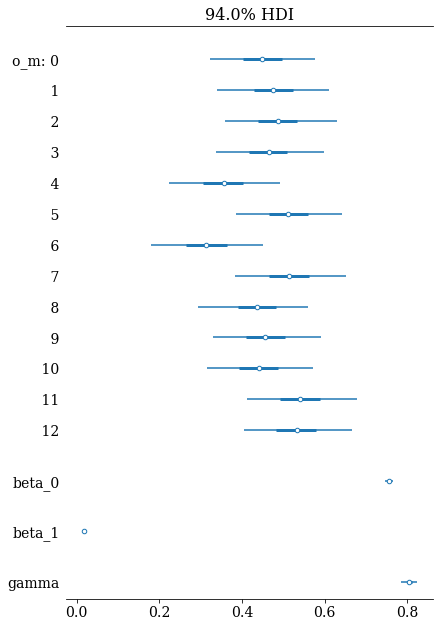

In [36]:
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

standard = 4000
years = pd.Series(poll_tax.index - 1905)
health_council_std = health_council / standard
orthodox_std = poll_tax.orthodox / standard
years = years[:-3]
health_council_std = health_council_std[:-3]
orthodox_std = orthodox_std[:-3]

with pm.Model() as model:
    t = pm.Data('t', years)
    n = len(years)
    beta_0 = pm.TruncatedNormal('beta_0', mu=0.75, sigma=0.02, lower=0.5, upper=1.)
    beta_1 = pm.TruncatedNormal('beta_1', mu=0.02, sigma=0.002, lower=0, upper=0.5)
    gamma = pm.TruncatedNormal('gamma', mu=0.8, sigma=0.01, lower=0.7, upper=0.95)
    mu_oh = beta_0 + beta_1 * t
    o_h = pm.Normal('o_h', mu_oh, sigma=0.01, observed=health_council_std)
    o_m = pm.Normal('o_m', mu=0.5, sigma=0.1, shape=n)
    mu_or = gamma * o_h - o_m
    sigma_or = np.diagflat([0.01] * n)
    o_r = pm.MvNormal('o_r', mu=mu_or, cov=sigma_or, shape=n, observed=orthodox_std)

    posterior = pm.sample(init="adapt_diag")
    prior_prediction = pm.sample_prior_predictive()
    posterior_prediction = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.94)

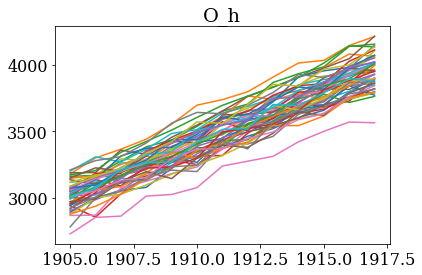

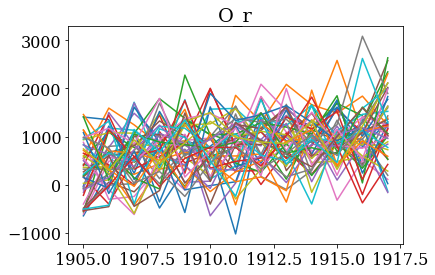

In [37]:
def plot_prediction(data, standard, skip=10):
    t = np.arange(1905, 1918, 1)
    o_h = data['o_h'][::skip, ] * standard
    o_r = data['o_r'][::skip, ] * standard

    for sample in o_h:
        plt.plot(t, sample)
    plt.title('O_h')
    plt.show()

    for sample in o_r:
        plt.plot(t, sample)
    plt.title('O_r')
    plt.show()

plot_prediction(prior_prediction, standard=standard)
# plot_prediction(posterior_prediction, standard=standard)
